# Description
For this kaggle competition, we're tasked to come up with a machine learning model to accurately predict if a tweet content is disastrous or not.
If the tweet contains disastrous content, then we will label it at 1, and 0 otherwise. Since we're dealing with textual data, I'll be using RNN machine learning model
along with other techniques for word vectorization and embedding.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner as kt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from gensim.models import Word2Vec
from keras.optimizers import Adam

# Exploratory Data Analysis (EDA)

In [3]:
# Load the datasets
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [4]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


**Findings**
* training data has 7614 rows, and 5 columns
* looks like keyword and location might have null values or corrupted values. So we need to either drop these or transform them.

In [6]:
# Check for missing values
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

**Findings**
* We've confirmed that only keyword and location columns need to be taken care of

In [7]:
# Drop rows with missing keyword and location or replace with 'Unknown'
train_data['keyword'].fillna('Unknown', inplace=True)
train_data['location'].fillna('Unknown', inplace=True)

/tmp/ipykernel_30/2851767035.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['keyword'].fillna('Unknown', inplace=True)
/tmp/ipykernel_30/2851767035.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [8]:
# Double check that the null values have been replaced with 'Unknown'
train_data.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

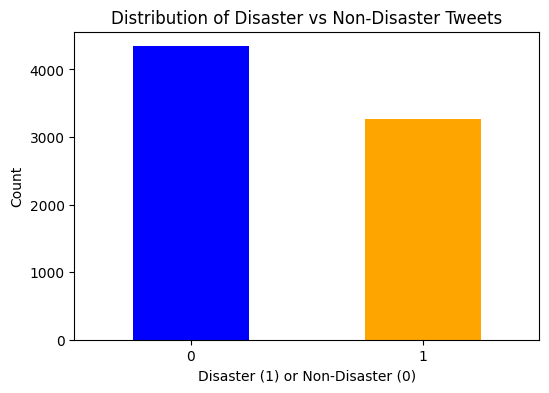

In [9]:
# Display distribution of Disaster vs Non-Disaster tweets
plt.figure(figsize=(6,4))
train_data['target'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Disaster vs Non-Disaster Tweets')
plt.xlabel('Disaster (1) or Non-Disaster (0)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

**Findings**
* Based on our training dataset, we can see that we have more non-disaster tweets than there are disaster tweets. However, it's relatively balanced.

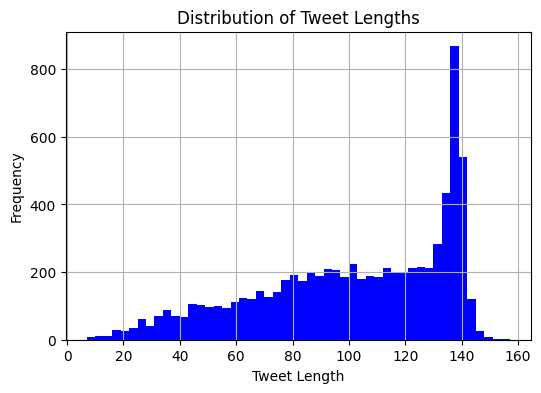

In [10]:
# We'll inspect lengths of tweets to see how they vary and see if we need to preprocess text data
train_data['text_length'] = train_data['text'].apply(len)

# Plot the distribution of tweet lengths
plt.figure(figsize=(6,4))
train_data['text_length'].hist(bins=50, color='blue')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

**Findings**
* Tweet lengths vary quite a bit, we will need padding.

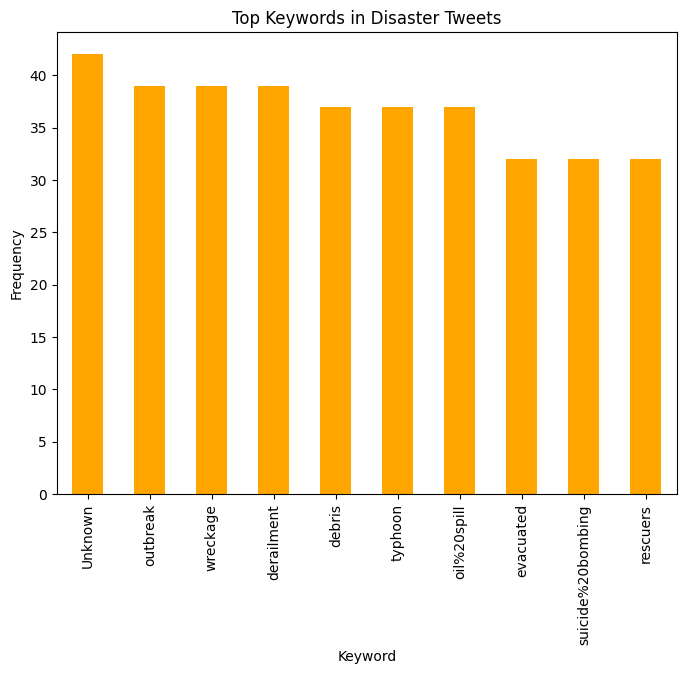

In [20]:
# We can also look at the most frequent keywords associated with disaster-related tweets, 
# so we have an idea which keywords are associated with disasters.
disaster_tweets = train_data[train_data['target']==1]
non_disaster_tweets = train_data[train_data['target']==0]

top_keywords = disaster_tweets['keyword'].value_counts().head(10)
plt.figure(figsize=(8, 6))
top_keywords.plot(kind='bar', color='orange')
plt.title('Top Keywords in Disaster Tweets')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.show()

# Model Architecture
We will be focusing on building a Recurrent Neural Network (RNN) model using Lngg Short-Term Memory (LSTM). LSTM models are pretty good at capturing sequential dependencies in text data. The general steps that we'll be taking here are text preprocessing, word embedding, building the models, and then training them.

**Steps**

We'll be using Word2Vec for the sequential model (RNN). The steps will be taking are:
1. Text Preprocessing: tokenize and pad the text data.
2. Word2Vec training: train a Word2Vec model on the text data to generate word embeddings.
3. Model Architecture: build RNN (LSTM) using the trained Word2Vec embeddings.
4. Train the model

**Text Preprocessing**

In [12]:
# Parameters
MAX_NB_WORDS = 20000  # Number of words to keep in the vocabulary
MAX_SEQUENCE_LENGTH = 100  # Maximum sequence length for each tweet
MAX_EMBED_DIM = 100

# Initialize the tokenizer and fit it on the text data
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_data['text'])

# Convert text to sequences (word indexes)
x_train_seq = tokenizer.texts_to_sequences(train_data['text'])

# Pad the sequences so that all inputs are of equal length
x_train_pad = pad_sequences(x_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Target variable (disaster or not)
y_train = train_data['target']

**Word2Vec Training**

In [13]:
# Prepare texts for Word2Vec
texts = train_data['text'].apply(lambda x: x.split())

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=texts, vector_size=MAX_EMBED_DIM, window=5, min_count=1, workers=4)
word2vec_model.save('word2vec_model.model')

**Building the Model**

In [14]:
# After training the Word2Vec model, we'll now create an embedding matrix to initialize the embedding
# layer in the RNN. Each word is mapped to a corresponding vector.
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, MAX_EMBED_DIM))

for word, indx in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[indx] = word2vec_model.wv[word]

In [15]:
# Define RNN model
model_word2vec = Sequential()
model_word2vec.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=MAX_EMBED_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))

# Add LSTM layer
model_word2vec.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

model_word2vec.add(Dense(1, activation='sigmoid'))

model_word2vec.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,270,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,100 (8.66 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,270,100 (8.66 MB)

**Model Training**

In [16]:
# Training the model
model_word2vec.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

trained_model = model_word2vec.fit(x_train_pad, y_train,
                                  epochs=5,
                                  batch_size=64,
                                  validation_split=0.1,
                                  verbose=2)

Epoch 1/5
108/108 - 17s - 161ms/step - accuracy: 0.5738 - loss: 0.6832 - val_accuracy: 0.5341 - val_loss: 0.6925
Epoch 2/5
108/108 - 13s - 117ms/step - accuracy: 0.5744 - loss: 0.6823 - val_accuracy: 0.5341 - val_loss: 0.6913
Epoch 3/5
108/108 - 12s - 113ms/step - accuracy: 0.5744 - loss: 0.6828 - val_accuracy: 0.5341 - val_loss: 0.6921
Epoch 4/5
108/108 - 12s - 113ms/step - accuracy: 0.5744 - loss: 0.6825 - val_accuracy: 0.5341 - val_loss: 0.6930
Epoch 5/5
108/108 - 13s - 116ms/step - accuracy: 0.5744 - loss: 0.6823 - val_accuracy: 0.5341 - val_loss: 0.6955


**Findings**

The accuracy is not very optimal and loss function is quite high as well. Let's try hyperparameter tuning to see if we can improve the performance.

# Hyperparameter Tuning

**Manual Parameter Tuning**

In [18]:
model_word2vec_tuned = Sequential()

# Embedding layer (same as before)
model_word2vec_tuned.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                                   output_dim=MAX_EMBED_DIM, 
                                   weights=[embedding_matrix], 
                                   input_length=MAX_SEQUENCE_LENGTH, 
                                   trainable=False))

# LSTM layer with tuned parameters
model_word2vec_tuned.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))  # Tuned units and dropout rate

# Dense output layer
model_word2vec_tuned.add(Dense(1, activation='sigmoid'))

# Compile the model with a different learning rate
optimizer = Adam(learning_rate=0.001)  # Tuned learning rate
model_word2vec_tuned.compile(loss='binary_crossentropy', 
                             optimizer=optimizer, 
                             metrics=['accuracy'])

# Train the model with tuned batch size and epochs
history_tuned = model_word2vec_tuned.fit(x_train_pad, y_train, 
                                         epochs=10,  # Tuned number of epochs
                                         batch_size=128,  # Tuned batch size
                                         validation_split=0.1, 
                                         verbose=2)

Epoch 1/10
54/54 - 8s - 152ms/step - accuracy: 0.5741 - loss: 0.6843 - val_accuracy: 0.5341 - val_loss: 0.6946
Epoch 2/10
54/54 - 6s - 118ms/step - accuracy: 0.5744 - loss: 0.6832 - val_accuracy: 0.5341 - val_loss: 0.6938
Epoch 3/10
54/54 - 6s - 113ms/step - accuracy: 0.5744 - loss: 0.6823 - val_accuracy: 0.5341 - val_loss: 0.6934
Epoch 4/10
54/54 - 6s - 111ms/step - accuracy: 0.5744 - loss: 0.6826 - val_accuracy: 0.5341 - val_loss: 0.6970
Epoch 5/10
54/54 - 6s - 112ms/step - accuracy: 0.5744 - loss: 0.6822 - val_accuracy: 0.5341 - val_loss: 0.6930
Epoch 6/10
54/54 - 6s - 110ms/step - accuracy: 0.5744 - loss: 0.6823 - val_accuracy: 0.5341 - val_loss: 0.6928
Epoch 7/10
54/54 - 6s - 115ms/step - accuracy: 0.5744 - loss: 0.6827 - val_accuracy: 0.5341 - val_loss: 0.6955
Epoch 8/10
54/54 - 6s - 115ms/step - accuracy: 0.5744 - loss: 0.6821 - val_accuracy: 0.5341 - val_loss: 0.6932
Epoch 9/10
54/54 - 6s - 112ms/step - accuracy: 0.5744 - loss: 0.6823 - val_accuracy: 0.5341 - val_loss: 0.6955
E

**Findings**

Manual tweaking parameters don't seem to have improved the performance by that much, let's try using Keras Tuner

**Keras Optimizers**

In [19]:
# Define a function for building the model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    
    # Embedding layer
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=MAX_EMBED_DIM,
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=False))

    # Tune the number of units in the LSTM layer
    model.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32), 
                   dropout=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1), 
                   recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  
    executions_per_trial=1,
    directory='kt_tuning',
    project_name='disaster_tweets')

tuner.search(x_train_pad, y_train, epochs=5, validation_split=0.1)

# Build the best model with tuned hyperparameters
best_model = tuner.hypermodel.build(tuner.get_best_hyperparameters(num_trials=1)[0])

# Train the best model
history = best_model.fit(x_train_pad, y_train, epochs=10, validation_split=0.1)


Trial 10 Complete [00h 02m 04s]
val_accuracy: 0.5341207385063171

Best val_accuracy So Far: 0.5341207385063171
Total elapsed time: 00h 21m 26s
Best LSTM units: 224
Best Dropout: 0.30000000000000004
Best Recurrent Dropout: 0.2
Best Learning Rate: 0.001
Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 26s 110ms/step - accuracy: 0.5611 - loss: 0.6874 - val_accuracy: 0.5341 - val_loss: 0.7016
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 24s 111ms/step - accuracy: 0.5713 - loss: 0.6837 - val_accuracy: 0.5341 - val_loss: 0.6972
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 24s 112ms/step - accuracy: 0.5787 - loss: 0.6811 - val_accuracy: 0.5341 - val_loss: 0.6957
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 24s 112ms/step - accuracy: 0.5732 - loss: 0.6829 - val_accuracy: 0.5341 - val_loss: 0.6941
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 24s 113ms/step - accuracy: 0.5703 - loss: 0.6838 - val_accuracy: 0.5341 - val_loss: 0.6980
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - accuracy: 0.5730 - loss: 0.6834 - va

**Findings**

The accuracy score hasn't really improved by a whole much even with keras optimizer.

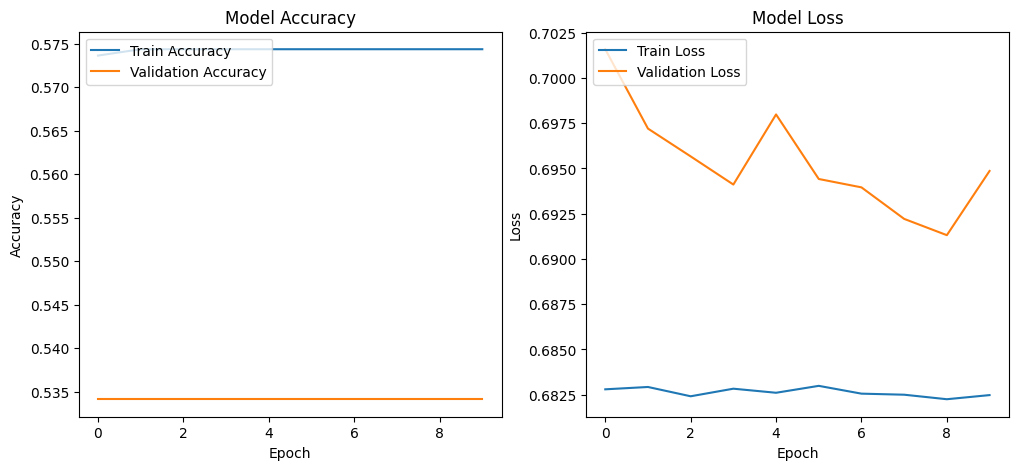

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Display the plots
plt.show()

# Conclusion
* The training and validation accuracy are both low, indicating that the model is perhaps underfitting as it is not complex enough to capture the patterns.
* The model may need more complexity such as adding more LSTM units, layers, or embedding dimensions.
* Also, it could be the data is too noisy, containing too many slangs, abbreviations, emojis and special characters.
* Some improvements I could try in the future could be using GloVe instead of Word2Vec as Word2Vec is pre-trained.
* Data could also be cleaned up better.

# Submission

In [31]:
test_data['keyword'].fillna('Unknown', inplace=True)
test_data['location'].fillna('Unknown', inplace=True)

# Parameters
MAX_NB_WORDS = 20000  # Number of words to keep in the vocabulary
MAX_SEQUENCE_LENGTH = 100  # Maximum sequence length for each tweet
MAX_EMBED_DIM = 100

# Initialize the tokenizer and fit it on the text data
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(test_data['text'])

# Convert text to sequences (word indexes)
x_test_seq = tokenizer.texts_to_sequences(test_data['text'])

# Pad the sequences so that all inputs are of equal length
x_test_pad = pad_sequences(x_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

pred = best_model.predict(x_test_pad)
predictions = (pred > 0.5).astype(int)

submission = pd.DataFrame({
    'id': test_data['id'],
    'target': predictions.flatten()
})

submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step
